In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap, ops
from jax import random
import numpy as np
import jax
from jax.scipy.linalg import expm
from jax.scipy import linalg
import eigAD
from jax.config import config   
config.update("jax_enable_x64", True)

In [2]:
# tunning parameter (constant in grad)
numStates=25
numSteps=31
numBands=5
fr=25.18
kpoints=250
kvec=jnp.linspace(-1,0,kpoints)

def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)


C = []
for i in range(2,numStates,2):
    C = C + [0,i]
C = np.array(C)
D = np.zeros(numStates)
M1 = tridiag(C,D,-1 * C)

E = [0]
for i in range(2,numStates,2):
    E = E + [(i)**2,(i)**2]
M2 = np.array(-np.diag(E))


F = np.concatenate((np.array([np.sqrt(2)]), np.ones(numStates-3)))
M3 = np.diag(F,-2) + np.diag(F,2)

In [3]:
freq = 70.0
Ttot = 1/freq
ftot = 1/Ttot
dT = Ttot/numSteps
N = 31

tVec = jnp.linspace(0,Ttot,N)
dT = tVec[1] - tVec[0]
tVec = tVec[:-1]
tVec = tVec + dT/2
modfunc = 1 + 0.5 * jnp.sin(2 * jnp.pi * freq * tVec)

In [8]:
# freqs: driving frequencies
# alphas: driving strength

M1 = jnp.asarray(M1)
M2 = jnp.asarray(M2)
M3 = jnp.asarray(M3)

def computeFloquetLoss(modulation):
    
    A = modulation[0]
    modulation = modulation[1:]
    dTau = (2 * jnp.pi * fr) * dT

    @jax.jit
    def perKstep(k):
        unitaryInit = jnp.identity(M1.shape[0],dtype=jnp.complex128)

        @jax.jit
        def scanf(unitary,tIdx):
            dU = expm(-1j * dTau * createHmat(tIdx,k))
            dU = jnp.asarray(dU)
            unitary = jnp.asarray(unitary)
            unitary = jnp.matmul(unitary,dU)
            return unitary,0

        res, _ = jax.lax.scan(scanf,unitaryInit,jnp.arange(N))
        return res


    @jax.jit
    def createHmat(tIdx,k):
        newMat = (k**2) * jnp.identity(numStates,dtype=jnp.complex128) - 2* 1j * k * M1 -M2  - (1/4) * M3 * A * modulation[tIdx]
        return newMat
    

    def genUni():
        kMap = vmap(perKstep)
        return kMap(kvec)

    res = genUni()

    def eigWrapper(mat):
        return eigAD.eig(mat)

    eigWrapper= jax.jit(eigWrapper,backend='cpu')
    eigWrapper= vmap(eigWrapper)
    b,vF = eigWrapper(res)
    rawEfloquet = jnp.real(1j*jnp.log(b)* (ftot/fr) / (2*np.pi))
    
    @jax.jit
    def blochStates(i):
        k = kvec[i]
        currF = vF[i,:,:] 
        H0 =  (k**2) * jnp.identity(numStates) - 2* 1j * k * M1 -M2  - (1/4) * M3 * A 
        a,vS = jnp.linalg.eigh(H0)
        vS = jnp.transpose(vS)
        Cvec = jnp.matmul(vS,jnp.conjugate(currF))
        Pvec = jnp.multiply(Cvec,jnp.conjugate(Cvec))
        inds = jnp.argmax(jnp.real(Pvec),axis=1)
        Efloquet = rawEfloquet[i,inds[:numBands]]
        return Efloquet
    bandsF = vmap(blochStates)(jnp.arange(250))

    return bandsF[:,0]
    
    

In [5]:
callbacks = np.load("trivial.npy")

In [19]:
losses = [computeFloquetLoss(jnp.array(callbacks[i,:])) for i in range(callbacks.shape[0])]

In [11]:
res = computeFloquetLoss(jnp.array(callbacks[-1,:]))

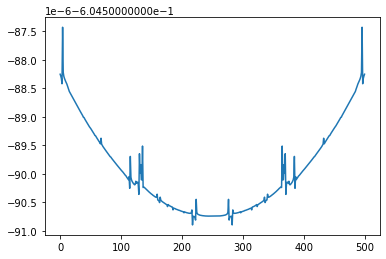

In [14]:
bandsF = res
mirror = jnp.flip(bandsF,axis=0)
bandsF = jnp.concatenate((bandsF,mirror),axis=0)
import matplotlib.pyplot as plt
plt.plot(bandsF)

In [15]:
callbacks[-1,:]

array([73.070819  , 13.10087561, 13.17177756, 13.35317954, 13.76508492,
       14.34846934, 14.30883127, 12.68944963, 10.3295133 ,  9.55823239,
       11.07237646, 13.46693684, 15.24523967, 16.2120579 , 16.34824207,
       14.9726744 , 12.30711587, 10.25478627, 11.14088894, 14.78294761,
       18.55204955, 20.52681664, 20.7702244 , 19.6471135 , 17.22924237,
       14.32638902, 12.59981959, 12.76282181, 13.48051289, 13.65018194,
       13.34943847])